In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams.update({'font.size': 11})

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
# Disable scientific notation globally
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
%%capture
# We need to alter the working directory since the scripts are written expecting that ./time_to_failure will be the working directory
%cd ..

# Read Data

Note - `train_scania.csv.gz` is a panel dataset, where a sample of vehicles are repeated observed over time. The data are an **imbalanced panel**, in that the number of times a particular vehicle is observed over time is not the same across vehicles. This contrasts with a **balanced panel**, where each unit is observed the same number of times over time (but possibly not at the same timepoint).

In [3]:
df = pd.read_csv("./data/train_scania.csv.gz", compression='infer')
df = df.sort_values(by=['vehicle_id', 'time_step']).reset_index(drop=True)

# Exploratory Data Analysis

In [4]:
df.shape

(1104234, 116)

In [5]:
df.head()

,vehicle_id,time_step,in_study_repair,100_0,158_0,158_1,158_2,158_3,158_4,158_5,158_6,158_7,158_8,158_9,167_0,167_1,167_2,167_3,167_4,167_5,167_6,167_7,167_8,167_9,171_0,272_0,272_1,272_2,272_3,272_4,272_5,272_6,272_7,272_8,272_9,291_0,291_1,291_10,291_2,291_3,291_4,291_5,291_6,291_7,291_8,291_9,309_0,370_0,397_0,397_1,397_10,397_11,397_12,397_13,397_14,397_15,397_16,397_17,397_18,397_19,397_2,397_20,397_21,397_22,397_23,397_24,397_25,397_26,397_27,397_28,397_29,397_3,397_30,397_31,397_32,397_33,397_34,397_35,397_4,397_5,397_6,397_7,397_8,397_9,427_0,459_0,459_1,459_10,459_11,459_12,459_13,459_14,459_15,459_16,459_17,459_18,459_19,459_2,459_3,459_4,459_5,459_6,459_7,459_8,459_9,666_0,835_0,837_0,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,0.000000,11.200000,0.000000,858410.000000,97056.000000,2690052.000000,2945268.000000,788437.000000,687480.000000,595164.000000,491232.000000,532932.000000,809628.000000,505693.000000,4110.000000,1296420.000000,1628265.000000,630345.000000,1269525.000000,4772940.000000,2706706.000000,222225.000000,6240.000000,0.000000,167985.000000,1435083.000000,857662.000000,384579.000000,668642.000000,7239843.000000,398490.000000,3887.000000,0.000000,0.000000,0.000000,1227.000000,555.000000,66.000000,463.000000,925.000000,468.000000,225.000000,535.000000,516.000000,492.000000,729.000000,70.000000,0.000000,446956.000000,411420.000000,2813.000000,224.000000,53161.000000,178881.000000,138250.000000,13328.000000,3581.000000,88.000000,16361.000000,131601.000000,203024.000000,116541.000000,13506.000000,2856.000000,48.000000,6337.000000,105412.000000,95728.000000,15609.000000,1984.000000,8.000000,26636.000000,784.000000,150228.000000,261904.000000,93172.000000,17874.000000,452.000000,29156.000000,7616.000000,449537.000000,233352.000000,139920.000000,12648.000000,7413813.000000,203.676778,111.911500,637.901639,744.618944,880.866889,1272.323972,1847.623667,940.785694,2.900083,0.208444,0.056417,0.058444,147.265389,200.479944,230.306278,277.722417,315.748806,372.164528,864.246250,920.881111,10787.000000,8036751.000000,2296.000000,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
1,0.000000,11.400000,0.000000,860571.000000,97056.000000,2693100.000000,2947368.000000,788437.000000,687480.000000,595164.000000,491232.000000,532932.000000,809628.000000,505693.000000,4111.000000,1302855.000000,1628265.000000,630345.000000,1269526.000000,4772940.000000,2706706.000000,222225.000000,6240.000000,0.000000,167985.000000,1440661.000000,857662.000000,384579.000000,668642.000000,7239843.000000,398490.000000,3887.000000,0.000000,0.000000,0.000000,1230.000000,558.000000,66.000000,463.000000,925.000000,469.000000,226.000000,535.000000,516.000000,493.000000,729.000000,70.000000,0.000000,446964.000000,411420.000000,2813.000000,224.000000,53210.000000,178883.000000,138252.000000,13328.000000,3582.000000,88.000000,16368.000000,131601.000000,203027.000000,116542.000000,13507.000000,2856.000000,48.000000,6339.000000,105413.000000,95729.000000,15610.000000,1984.000000,8.000000,26638.000000,784.000000,150228.000000,261905.000000,93172.000000,17874.000000,452.000000,29157.000000,7616.000000,451193.000000,233354.000000,139920.000000,12649.000000,7413813.000000,204.256750,112.924250,637.901639,745.618944,880.866889,1272.323972,1847.623667,940.785694,2.900083,0.208444,0.056417,0.058444,147.265389,201.479944,230.306278,277.722417,315.748806,372.164528,864.246250,920.881111,10787.000000,8040811.000000,2296.000000,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
2,0.000000,19.600000,0.000000,1379191.000000,181632.000000,4249020.000000,4630440.000000,1539133.000000,1421172.000000,1039764.000000,749472.000000,740724.000000,995796.000000,574045.000000,4111.000000,1302855.000000,1628265.000000,630345.000000,1269526.000000,4772940.000000,2706706.000000,222225.000000,6240.000000,0.000000,331635.000000,1787736.000000,1133132.000000,598351.000000,1167062.000000,12314224.000000,460240.000000,3887.000000,0.000000,0.000000,0.000000,2136.000000,954.000000,162.000000,8

### Number of unique vehicles

In [6]:
print(f"Number of unique vehicles in df: {df['vehicle_id'].nunique():,}")

Number of unique vehicles in df: 23,150


### Distribution of number of observations per `vehicle_id`

In [7]:
obs_per_vehicle = df.groupby('vehicle_id')['time_step'].count()

In [8]:
obs_per_vehicle.describe()

count   23150.000000
mean       47.699093
std        27.438297
min         5.000000
25%        28.000000
50%        43.000000
75%        64.000000
max       303.000000
Name: time_step, dtype: float64

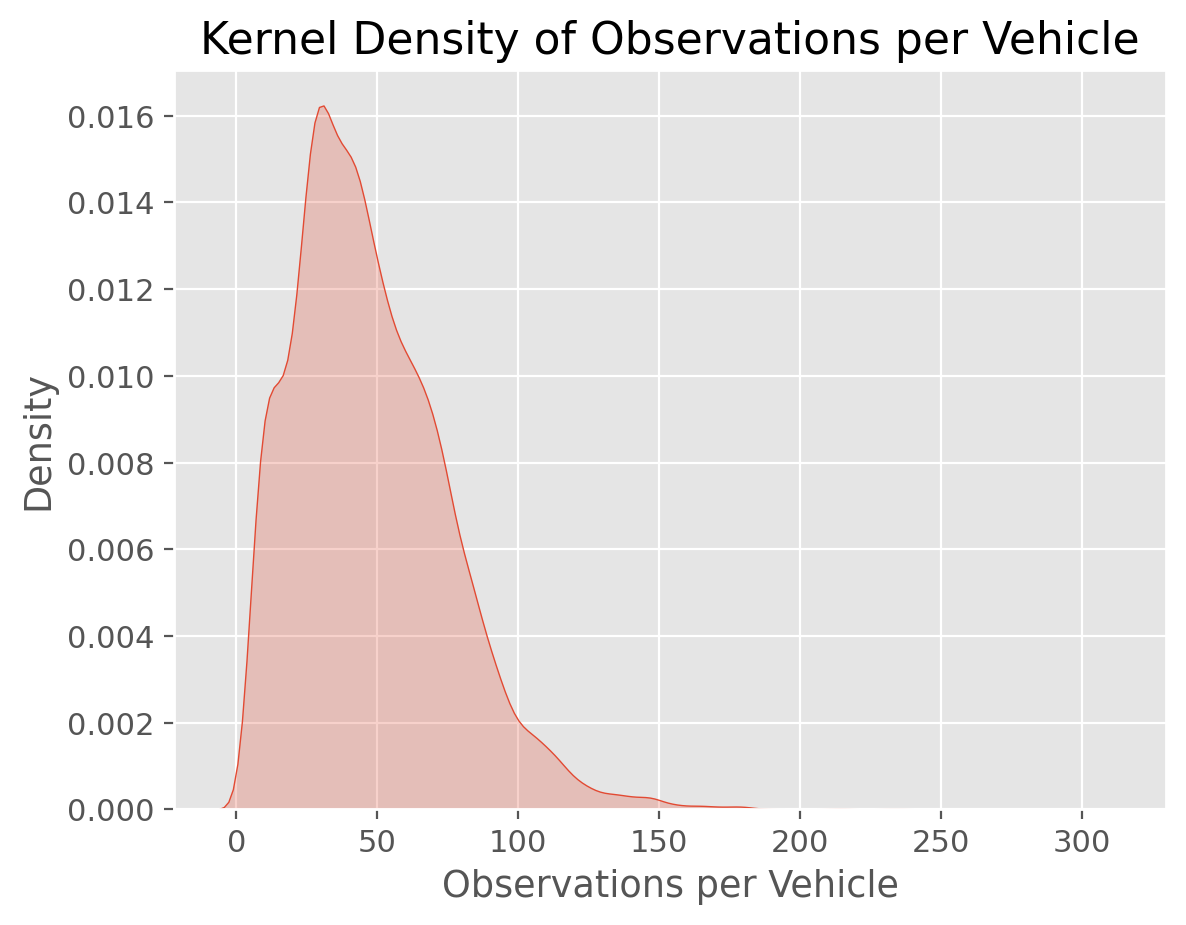

In [9]:
plt.rcParams.update({'font.size': 11})
sns.kdeplot(obs_per_vehicle, fill=True)
plt.xlabel('Observations per Vehicle')
plt.title('Kernel Density of Observations per Vehicle')
plt.show()

Given the variation in the number of time series observations per vehicle, it's paramount to downsample `vehicle_id`s with a high number of time series observations, otherwise these will dominate the loss function of the ML model during training. Note - this only applies if using the data as a panel, if using the data as a cross-section (i.e. by keeping only the last observation), this does not apply.

### Correlation matrix of panel data

In [10]:
# Pearson correlation (default)
correlation_matrix = df.select_dtypes(include=np.number).corr(method='pearson')

In [11]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(50,50))
sns.heatmap(abs(correlation_matrix),
            cmap='coolwarm',
            xticklabels=1,          # Show all xtick labels
            yticklabels=1,          # Show all ytick labels
            cbar_kws={'shrink': 0.8})  # Shrink color bar if necessary
plt.title('Feature Correlations', fontsize=36)
plt.show()

## Deduplication of panel data -> cross-section

To generate a survival curve (below) we must deduplicate the dataset, converting our panel dataset to a cross-sectional dataset. We do so by keeping the last time period for each `vehicle_id`.

In [12]:
undup = df.drop_duplicates(subset=['vehicle_id'], keep='last')

### Density of observed/censored survival time

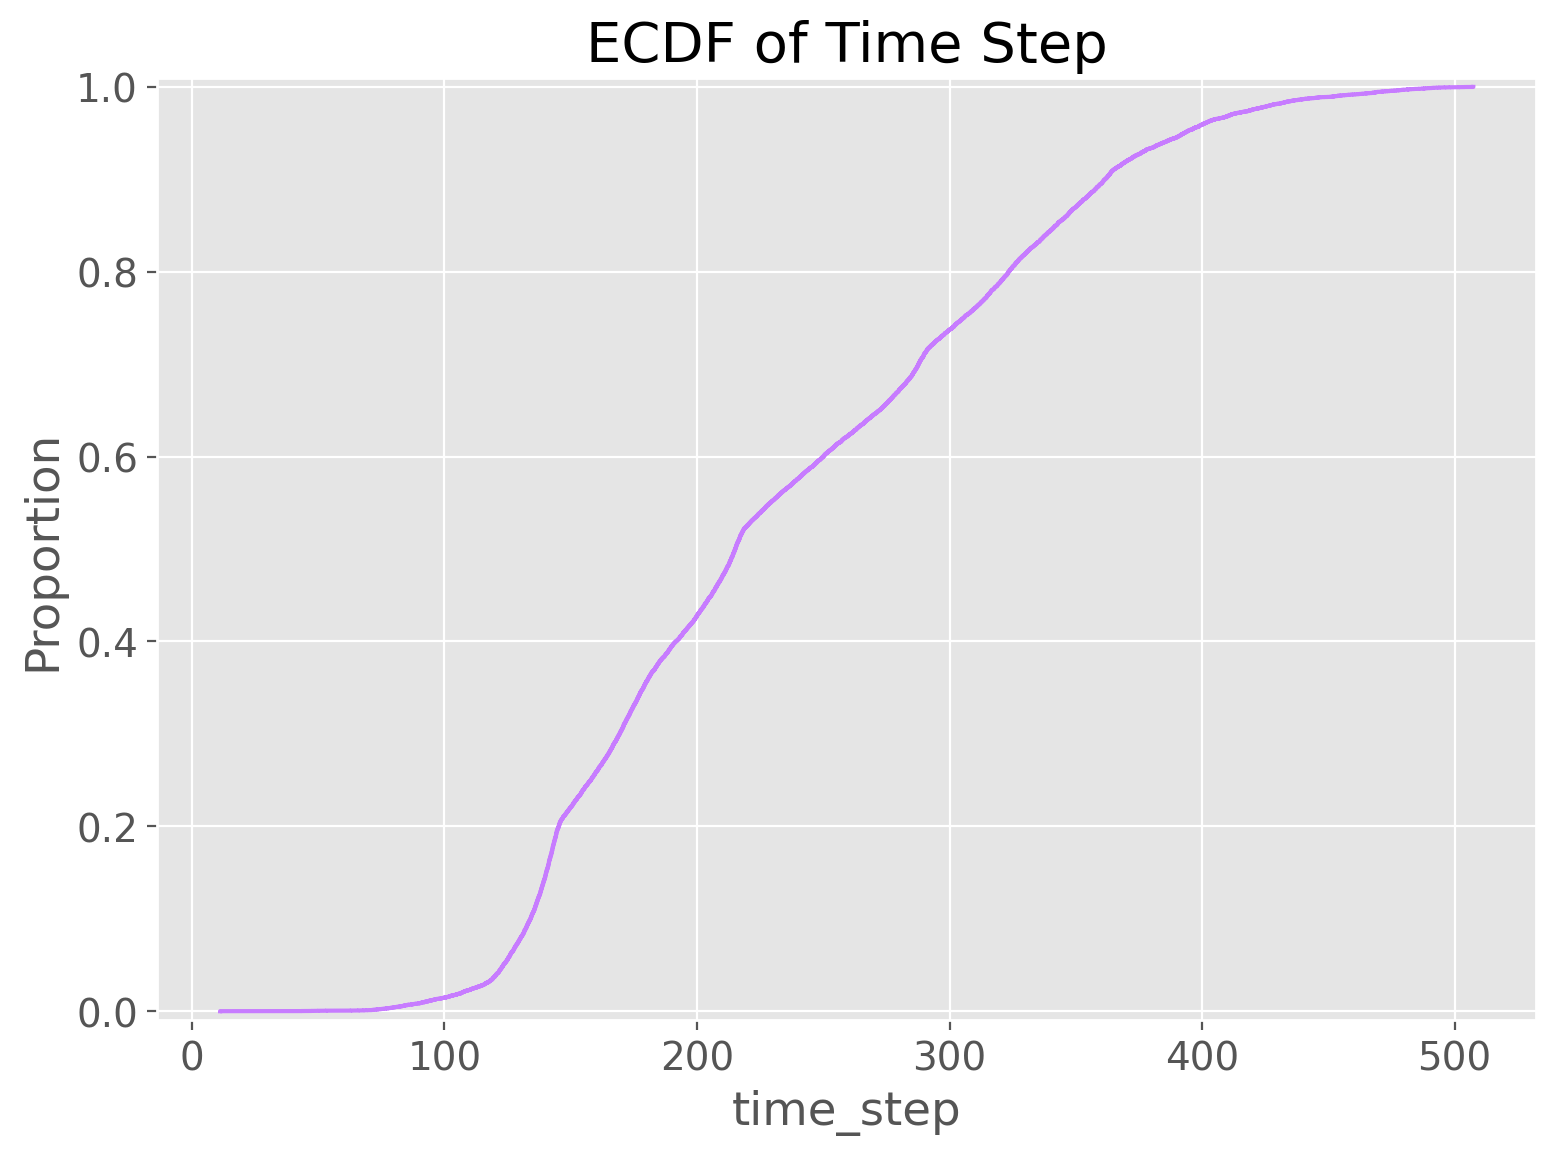

In [13]:
plt.figure(figsize=(8, 6))
sns.ecdfplot(undup['time_step'], color='#C77CFF')
plt.title('ECDF of Time Step')
plt.ylim(-0.01, 1.01)
plt.tight_layout()
plt.show()

### Density of survival times by censored/non-censored

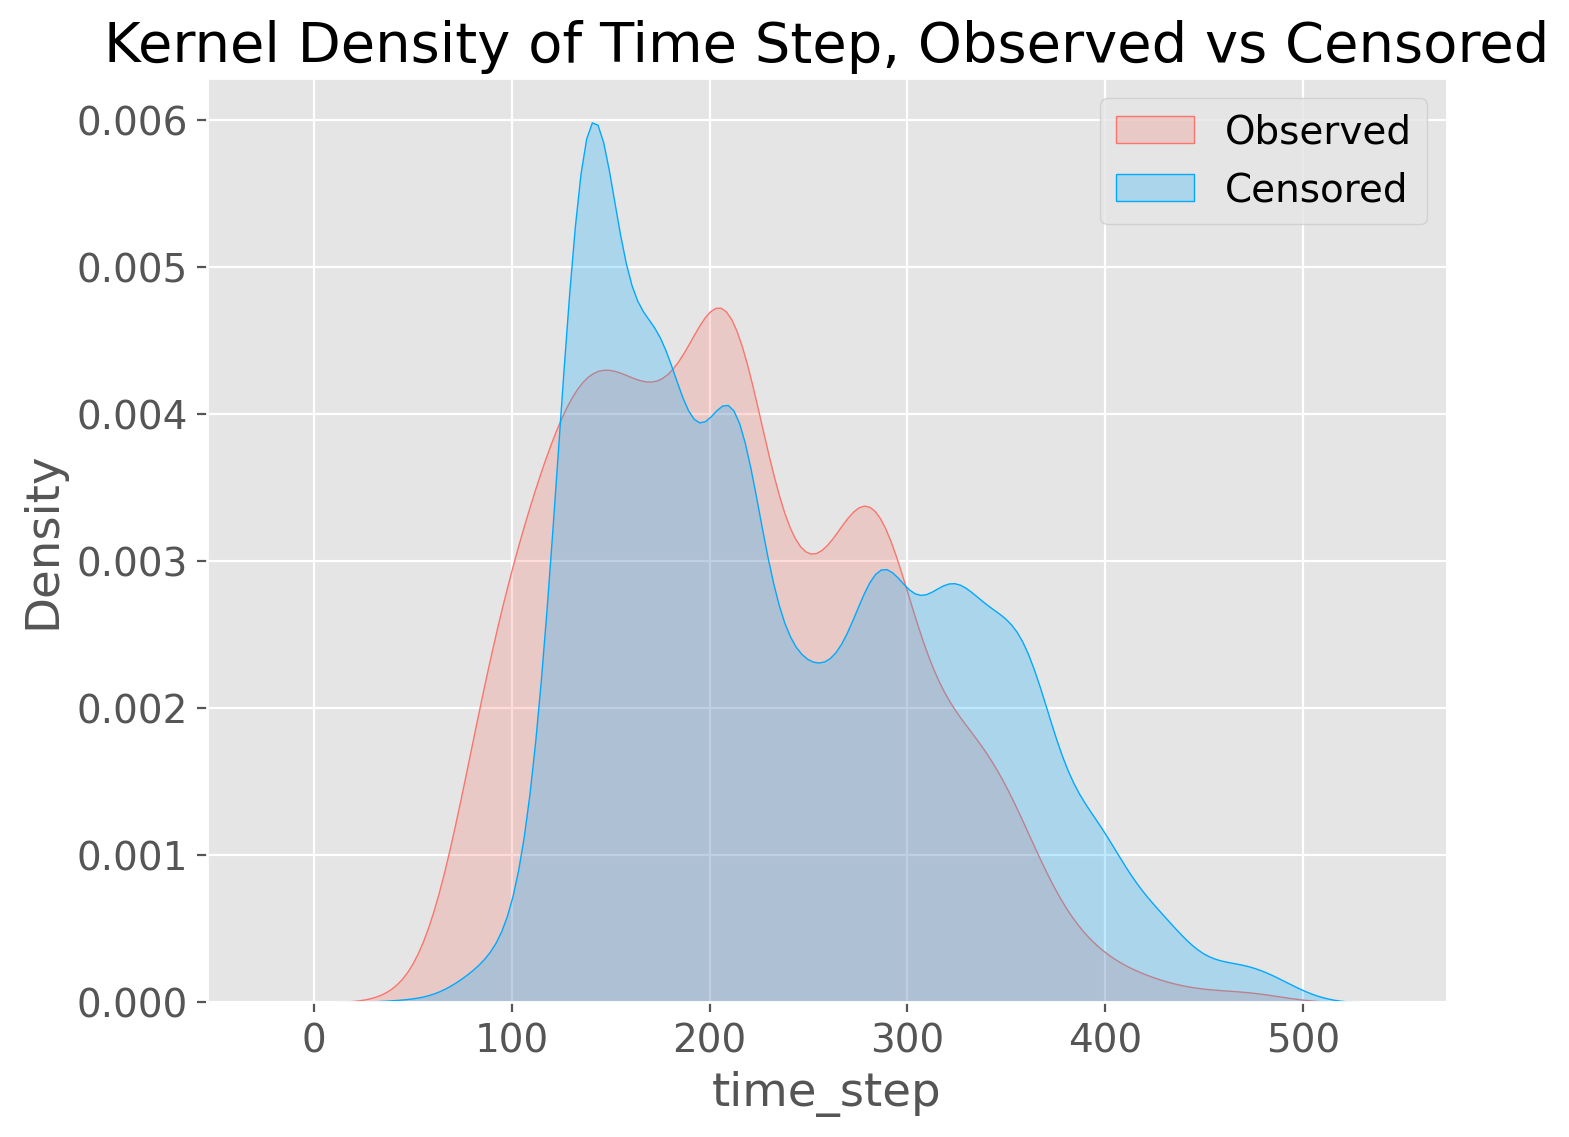

In [14]:
plt.figure(figsize=(8, 6))
sns.kdeplot(undup[undup['in_study_repair'] == 1]['time_step'], label='Observed', color='#F8766D', fill=True)
sns.kdeplot(undup[undup['in_study_repair'] == 0]['time_step'], label='Censored', color='#00A9FF', fill=True)
plt.legend()
plt.title('Kernel Density of Time Step, Observed vs Censored')
plt.show()

### Kaplan-Meier Survival Curve

Note - we restrict to the last observation per `vehicle_id`

In [15]:
print(f"Percentage of 'vehicle_id`s that were observed to have failed: {undup['in_study_repair'].mean()*100:.2f}%")

Percentage of 'vehicle_id`s that were observed to have failed: 9.64%


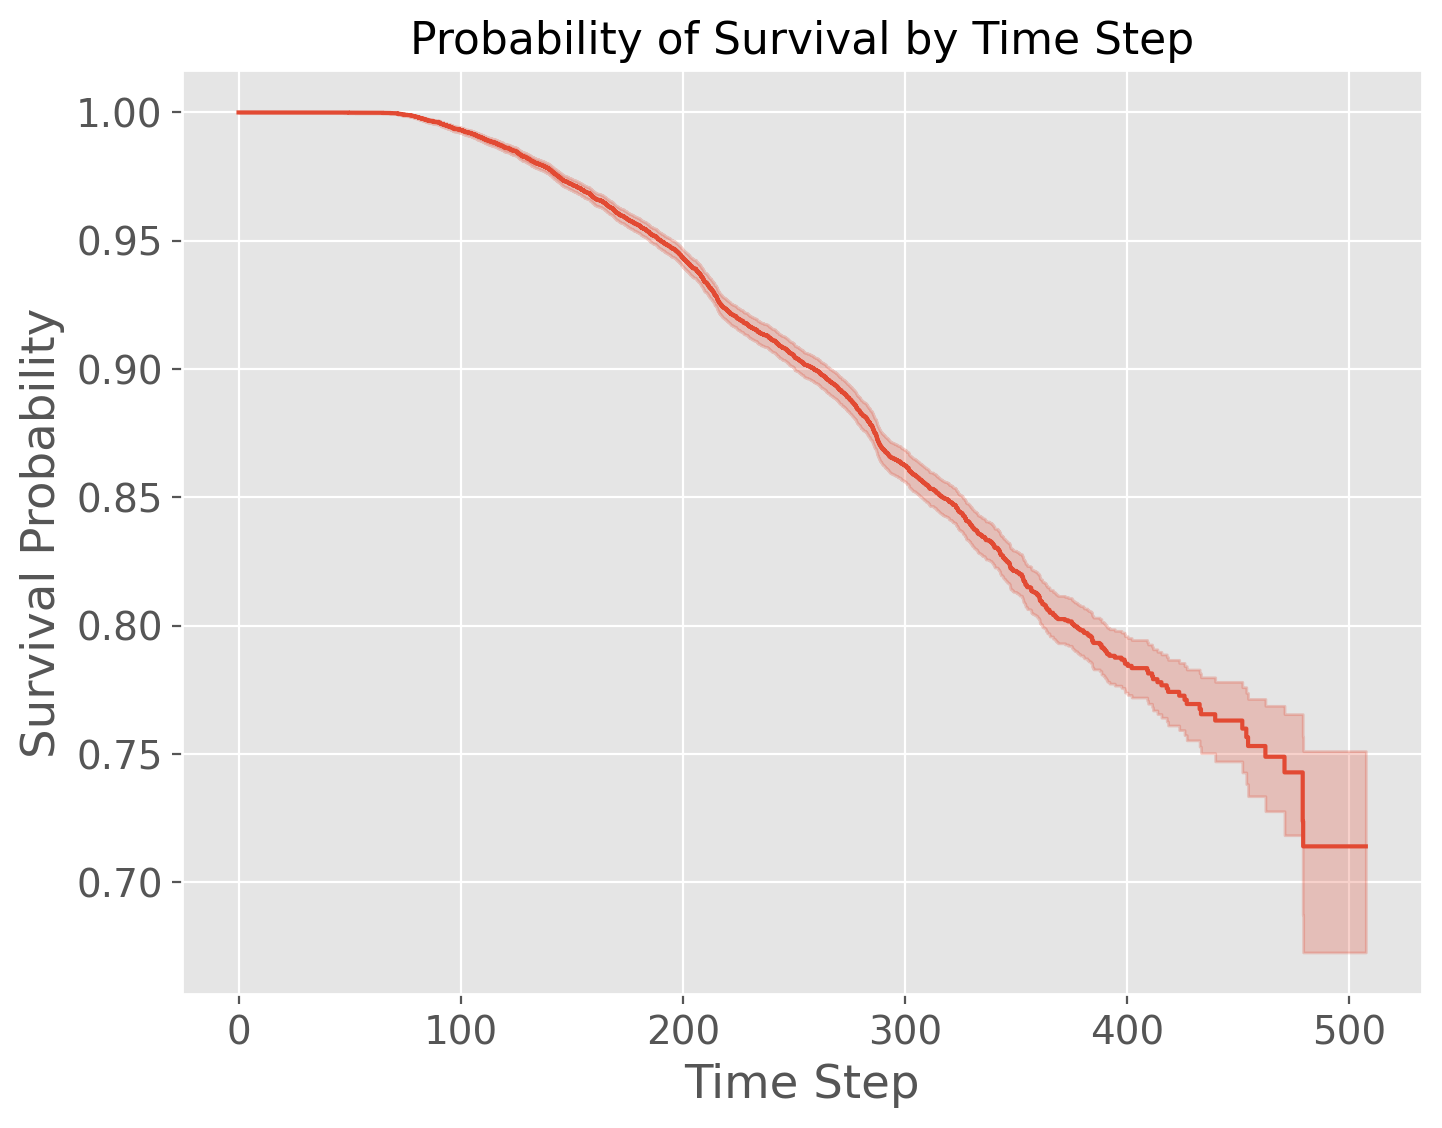

In [16]:
plt.figure(figsize=(8, 6))

kmf = KaplanMeierFitter()
kmf.fit(durations=undup['time_step'], event_observed=undup['in_study_repair'])

# Plot the Kaplan-Meier survival curve
ax = kmf.plot_survival_function()

# Suppress the legend
ax.get_legend().remove()
plt.rcParams.update({'font.size': 11})
plt.title('Probability of Survival by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Survival Probability')
plt.show()